# Adaptive Market Hyperparameters

This notebook is inspired by the Adaptive Markets Hypothesis book, by Andrew Lo (2017). 
The idea is that markets are adaptive. Mean-reversion and trend-following strategies are still around, but the hyperparameters vary as regimes change. 

Instead of predicting target returns, we will try to predict the trajectory of the optimal set of hyperparameters that describe the current state of the market. If the adaptive market hypothesis is somewhat akin to biological evolution, the parameter space should be rather smooth. That is, it should not jump around much over time but follow a continuous evolution.

For this analysis we'll investigate `FTSE`, `GLD`, `HSI`, `NKY`, `SPX`, and `VIX`.

We can also predict the speeds of convergence and divergence of VIX.

In [268]:
import re
import numpy as np
import pandas as pd
import pyarrow as pa
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from tqdm.notebook import tqdm

from data_analysis_toolbox import gscatter
import ultron

plt.rcParams['figure.figsize'] = [18, 5]
plt.rcParams['axes.grid'] = True
import matplotlib
font = {'size'   : 12}
matplotlib.rc('font', **font)
pd.set_option('display.max_rows', 200)

In [269]:
import pandas as pd

In [270]:
indices = !ls data/
indices

['ftse.csv', 'gld.csv', 'hsi.csv', 'nky.csv', 'spx.csv', 'vix.csv']

array([False, False, False, ...,  True,  True,  True])

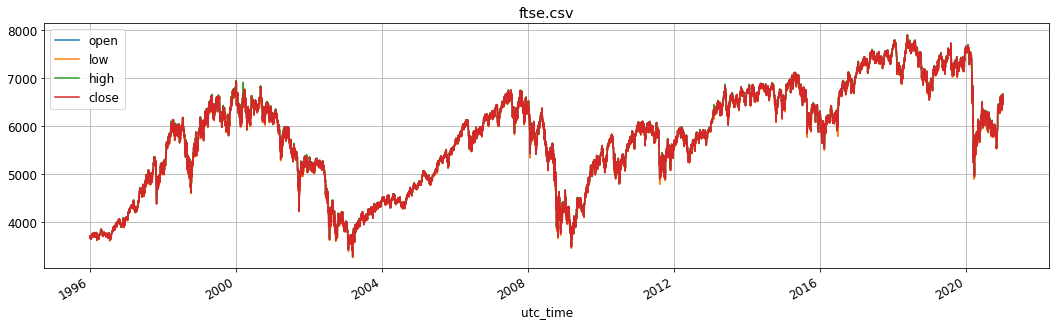

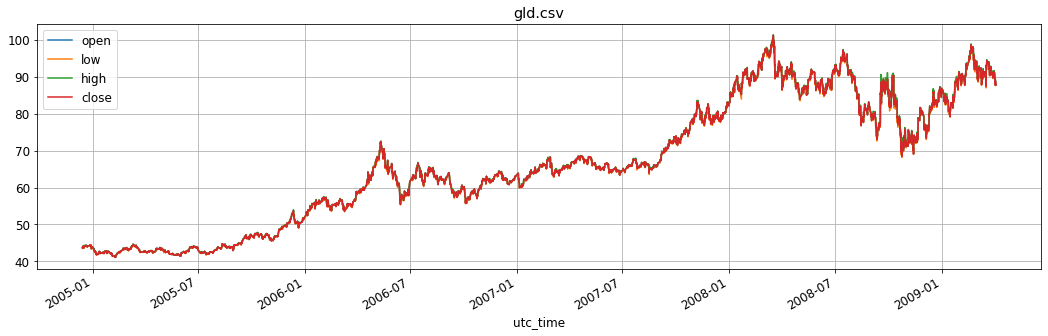

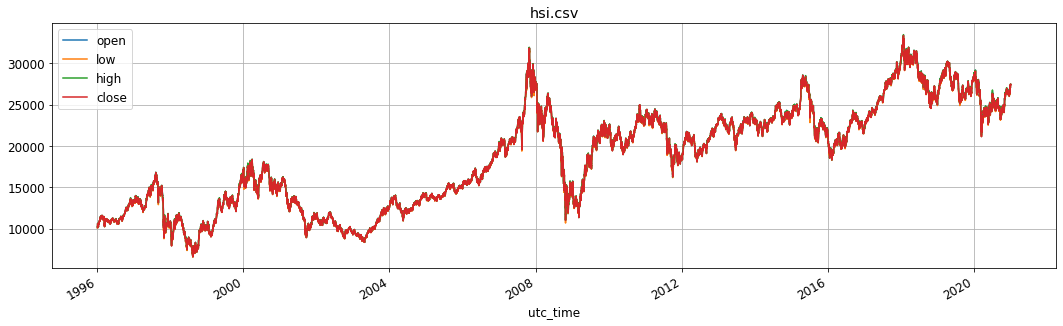

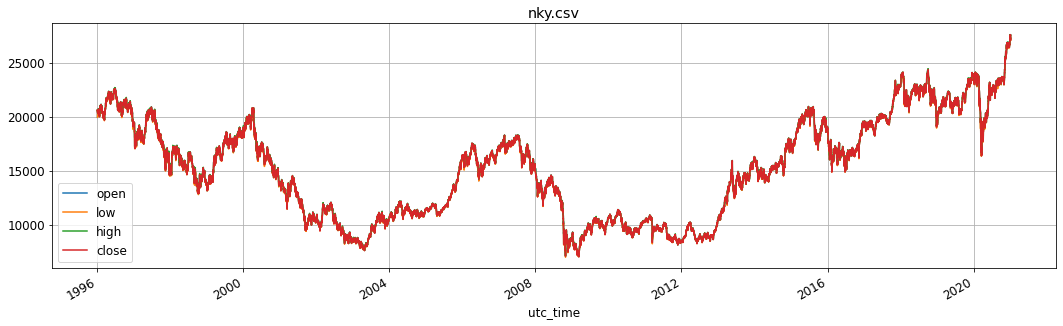

/home/ssl/pipshellstreet/swaps/lib/python3.7/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


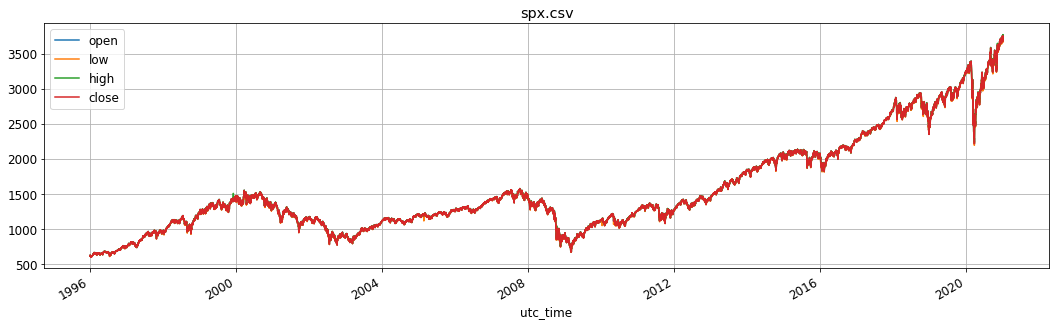

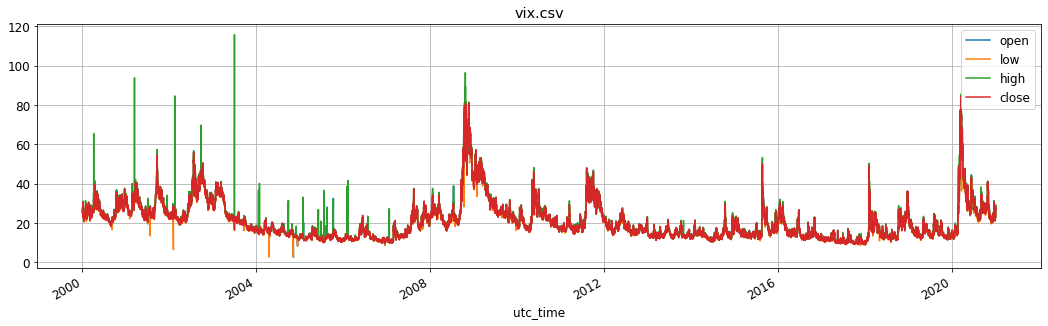

In [347]:
data = {}
for file in indices:
    data[file.split(".")[0]] = pd.read_csv('data/'+file, index_col=0, parse_dates=True)
    if 'hsi' in file:
        data['hsi'].loc[data['hsi'].low < 5_000, 'low'] = np.nan
        data['hsi']['low'].ffill(inplace=True)
        
    if 'spx' in file:
        data['spx'].loc[data['spx'].high > 5_000, 'high'] = np.nan
        data['spx'].loc[data['spx'].low < 500, 'low'] = np.nan
        data['spx'].loc[data['spx'].open < 500, 'open'] = np.nan
        data['spx'].loc[(data['spx'].index.year == 2004) & (data['spx'].high > 1500), 'high'] = np.nan
        data['spx'][['high', 'low', 'open']].ffill(inplace=True)
        
    data[file.split(".")[0]][['open', 'low', 'high', 'close']].plot()
    plt.title(file)
    plt.show()

In [348]:
data.keys()
spx = data['spx']

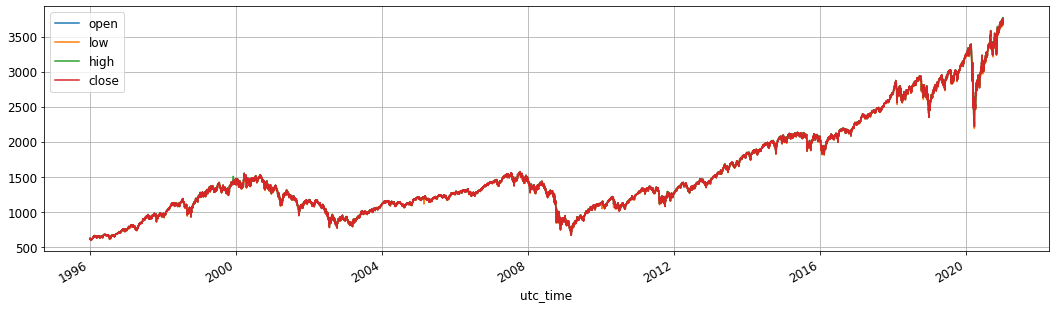

In [351]:
spx[['open', 'low', 'high', 'close']].plot();

In [352]:
yclose = spx.resample('1D').close.last().dropna().shift().dropna()
yclose.name = 'yesterday_close'
spx = pd.concat([yclose, spx], axis=1)
spx['yesterday_close'] = spx['yesterday_close'].shift()
spx.dropna(axis=0, how='all', inplace=True)
spx['yesterday_close'] = spx['yesterday_close'].ffill()

In [353]:
hours_per_day = int(spx.groupby(spx.index.date).count().mean().close)

In [354]:
def get_atr(prices):
    dates = pd.Series(prices.index.date).drop_duplicates().values
    atr = []
    for d in tqdm(dates):
        day = prices.loc[str(d)]
        tr = pd.concat([(day.high.cummax() - day.low.cummin()), 
                         np.abs(day.high.cummax() - day.yesterday_close),
                         np.abs(day.low.cummin() - day.yesterday_close)], axis=1)
        atr.append(tr.max(axis=1))

    return pd.concat(atr)
atr = get_atr(spx)
spx['atr'] = atr.rolling(30*hours_per_day).mean()

## Benjamin's Signal

It's basically when WMA(p(t),30)-WMA(p(t-1),30)=0.   

It can be shown with a bit of algebra that this is the same condition as when the current price p(t) 
is equal to the 30 week simple  moving average, ie, p(t)=SMA(p(t),30).  I'm being a bit sloppy by saying "equal", but it's when it "crosses" that line. 

It would be interesting to scan equities that have options for such trigger points, 
look at the skew for those equities (if options exist) and then layer on top some machine learning based metric of "view".  maybe using sentiment, some information from FactSet etc.

In [355]:
span = 10
hrsperday = int(spx.groupby(spx.index.date).count().close.mean())
ts = spx['close']

<AxesSubplot:xlabel='utc_time'>

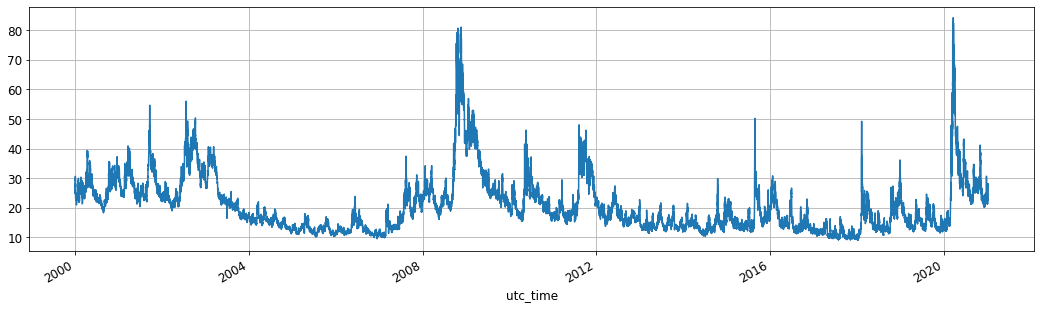

In [356]:
data['vix']['close'].plot()

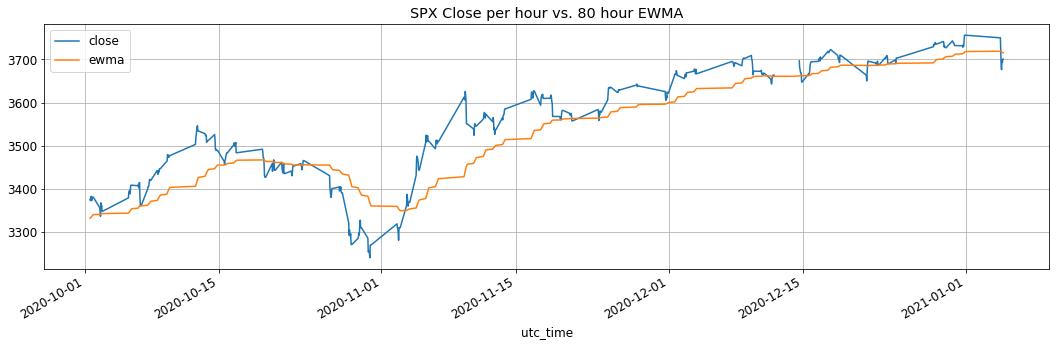

In [357]:
x = pd.concat([ts, ts.ewm(span=span*hrsperday).mean()], axis=1)
x.columns = ['close', 'ewma']
x['2020-10':].plot()
plt.title("SPX Close per hour vs. 80 hour EWMA")
plt.legend();
plt.show();

In [385]:
from orion import Orion

hyperparameters = {
    'keras.Sequential.LSTMTimeSeriesRegressor#1': {
        'epochs': 5,
        'verbose': True
    }
}

orion = Orion(
    pipeline='lstm_dynamic_threshold',
    hyperparameters=hyperparameters
)

orion.fit(data['spx'])

ValueError: Unknown pipeline: lstm_dynamic_threshold

In [358]:
def stats_from_pnl(pnl):
    stats = {}
    daily_pnl = pnl.resample('1D').last().dropna()
    stats['sharpe'] = (daily_pnl.diff().mean() / daily_pnl.diff().std()) * np.sqrt(250)
    stats['dd'] = (pnl.cummax() - pnl).max()
    stats['name'] = pnl.name
    return stats

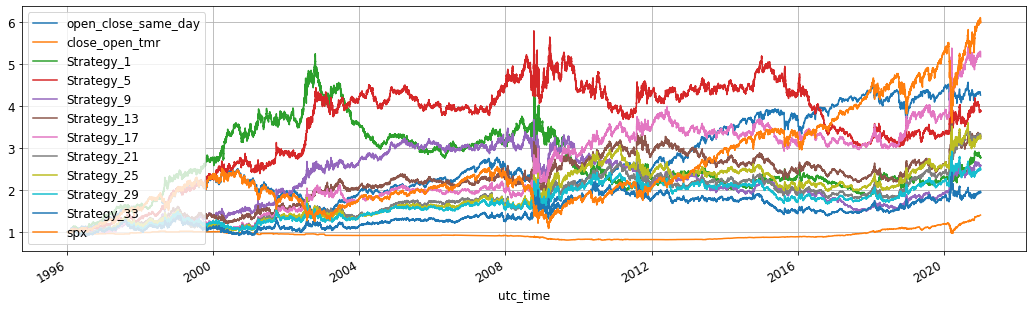

In [365]:
index_name = 'spx'
ts = data[index_name]['close']
all_stats = []
pnls = []

# Skip overnight trades
x = spx.resample('1D').agg({'open':'first', 'close': 'last'}).dropna()
rets = (x.close - x.open)/ x.open
pnl = (1+rets).cumprod()
pnl.name = 'open_close_same_day'
pnl.plot()
pnls.append(pnl)
all_stats.append(stats_from_pnl(pnl))

# Only trade overnight
rets = (x.open - x.close.shift(1))/ x.close.shift(1)
pnl = (1+rets).cumprod()
pnl.name = 'close_open_tmr'
pnl.plot()
pnls.append(pnl)
all_stats.append(stats_from_pnl(pnl))

windows = list(range(1, 35, 4))
for i in windows:
    pos = (ts - ts.ewm(span=i*hrsperday).mean()).apply(np.sign).shift()
    pos = pos * ts.pct_change()
    pnl = (1 + pos).cumprod()
    pnl.name = 'Strategy_'+str(i)
    pnls.append(pnl)
    pnl.plot();
    all_stats.append(stats_from_pnl(pnl))
    
index = (1+ts.pct_change()).cumprod()
index.name = index_name
all_stats.append(stats_from_pnl(index))
    
all_stats = pd.DataFrame(all_stats).set_index('name')
index.plot()
plt.legend();
pnls = pd.concat(pnls, axis=1)

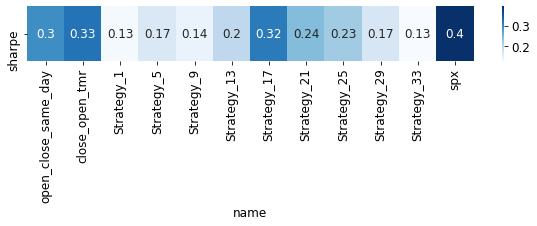

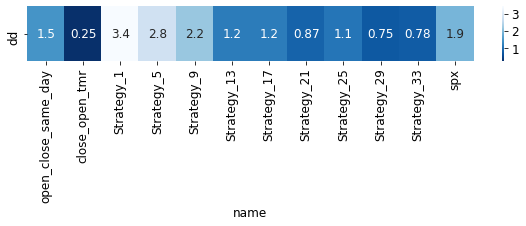

In [361]:
plt.figure(figsize=(10, 1))
sns.heatmap(all_stats[['sharpe']].T, cmap='Blues', annot=True)

plt.figure(figsize=(10, 1))
sns.heatmap(all_stats[['dd']].T, cmap='Blues_r', annot=True);

### Naive way - change the model every hour based on the performance of the past day.

In [195]:
ts

utc_time
1996-01-02 15:00:00     614.21
1996-01-02 16:00:00     618.71
1996-01-02 17:00:00     617.38
1996-01-02 18:00:00     617.81
1996-01-02 19:00:00     618.39
                        ...   
2021-01-04 18:00:00    3676.17
2021-01-04 19:00:00    3699.53
2021-01-04 20:00:00    3693.23
2021-01-04 21:00:00    3700.65
2021-01-04 22:00:00    3700.65
Name: close, Length: 50384, dtype: float64

In [194]:
for date in ts.index:
    sample = ts.loc[:date]

utc_time
1996-01-02 15:00:00     614.21
1996-01-02 16:00:00     618.71
1996-01-02 17:00:00     617.38
1996-01-02 18:00:00     617.81
1996-01-02 19:00:00     618.39
                        ...   
2021-01-04 18:00:00    3676.17
2021-01-04 19:00:00    3699.53
2021-01-04 20:00:00    3693.23
2021-01-04 21:00:00    3700.65
2021-01-04 22:00:00    3700.65
Name: close, Length: 50384, dtype: float64

## How do we find regimes?
https://www.analyticsvidhya.com/blog/2019/10/regime-shift-models-time-series-modeling-financial-markets/

1. Threshold Models
2. Predictive Models
3. Markov Switching Autoregressive Models

### 1. Threshold Models
These are pretty simple. Let's do 200-day moving average crossing as a new regime.

## We test mean-reversion and trend-following and see what are the days under which it works best.

What we want is to test just one parameter at a time. This way, we can see how quickly people process information - how fast one should trade as time goes on. This way, maybe we can start predicting hyperparameters instead of the actual time series.

### Trend Following

Trend following tells you to bet on the winners and short the losers. _Follow the trend._

There are a gazillion trend following strategies, but they all come down to past performance of the stock being indicative of future returns.  This is terrible trading advise, but we want to see what we can find here. We are not predicting direction - rather, we are attempting to describe the current behavior. Nowcasting, per se.

### Mean-Reversion

For mean reversion, we do a simple MACD strategy.

In [ ]:
#### More involved

In [202]:
### PARAMETERS
ewma_span = 100
atr_window = 14

In [163]:
ts = spx['close']

In [575]:
def transform_feature(feat, feat_diff=None, ewma_span=None, zscore_span=10):
    """Return a transformed feature as a pd.Series:
        zscore of ( feat.diff().ewm().mean() )
    """
#     feat = (feat.diff(feat_diff)
#                     .ewm(span=ewma_span)
#                     .mean())

    rollingmean = (feat.rolling(window=zscore_span)
                           .mean())

    rollingstd = (feat.rolling(window=zscore_span)
                          .std(ddof=0))

    zscore = (feat - rollingmean) / rollingstd
    zscore.name = 'zscore_' + zscore.name
    return zscore

In [577]:
zscore = transform_feature(spx['close'], zscore_span=10)

In [ ]:
get_pos

In [579]:
def get_positions_from_signal(signal, entry, exit):
    """ Given an entry and an exit from the config file, as well as a
        pandas series as the signal,

    -Goes long a position if t-1 was above entry and if t is below entry.
    -Goes short a position if t-1 was below -(entry) and if t is above -(entry)
    -Exits (or maintains closed) the position if t is between -(exit) and exit.

    :return:
        Time series of positions.
    """
    thresholded_signal = signal.copy()
    thresholded_signal.dropna(inplace=True)
    thresholded_signal.loc[
            (thresholded_signal > -entry) & 
            (thresholded_signal < entry)] = 0

    entry_signal = thresholded_signal.apply(np.sign)
    
    positions = pd.Series(0, index=entry_signal.index)
    positions.loc[(entry_signal==0) & entry_signal.diff()!=0] = signal
    positions = positions.replace(0, np.nan)

    close = pd.Series(1, index=entry_signal.index)
    close.loc[(signal > abs(exit))] = 0
    close = close.diff().replace(0, np.nan).dropna()*0

    positions.loc[close.index] = close

    close = pd.Series(1, index=entry_signal.index)
    close.loc[(signal < -abs(exit))] = 0
    close = close.diff().replace(0, np.nan).dropna()*0

    positions.loc[close.index] = close

    # Buy when signal is coming up, sell when signal is coming down
    positions = np.sign(-1 * positions.ffill())
    positions.name = 'positions'
    return positions

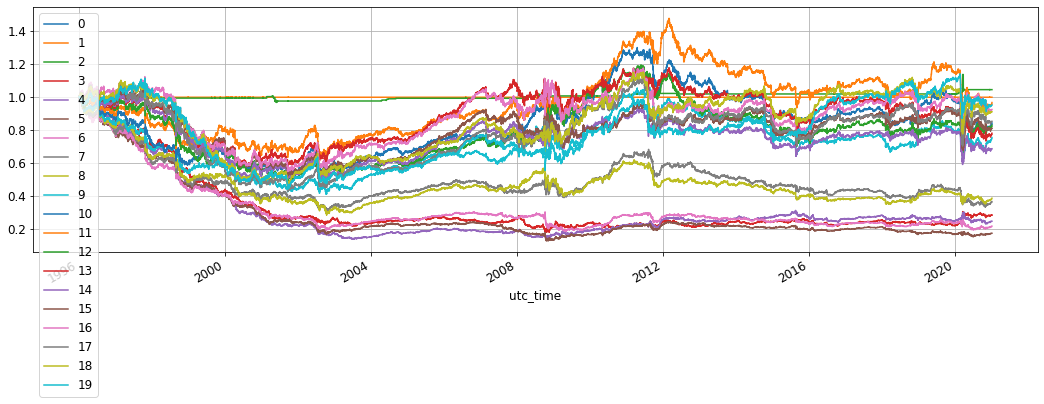

In [672]:
for i in range(20):
    pos = get_positions_from_signal(
        transform_feature(spx['close'], zscore_span=i),
        entry=1,
        exit=0
    )
    pnl = pos.shift() * spx['close'].pct_change()
    ((1+pnl).cumprod()).plot(label=i)
    
plt.legend()
plt.show()

### Addition to Indexes

In [100]:
import ultron

In [114]:
all_tags = ultron.edf_get_tag_descriptions()

In [110]:
tags = ['NDXCHG','THMRFOTR', 'NDXUP']

In [128]:
stories = ultron.edf_get_analytics_story(start_date='2020-01-01', end_date='2020-10-01', tags=tags, intersection=False)
stories.set_index('ts_arrival', inplace=True)

Found 4830 article(s)
{'query': {'bool': {'filter': [{'range': {'ts_update': {'gte': datetime.datetime(2020, 1, 1, 0, 0),
                                                        'lt': datetime.datetime(2020, 10, 1, 0, 0)}}}],
                    'must': [{'match': {'event_type': 'analytic'}},
                             {'bool': {'minimum_should_match': 1,
                                       'should': [{'match': {'parsed_DerivedTopics.Id': 'NDXCHG'}},
                                                  {'match': {'parsed_DerivedTopics.Id': 'THMRFOTR'}},
                                                  {'match': {'parsed_DerivedTopics.Id': 'NDXUP'}}]}}]}}}


In [132]:
stories

,id,ts_bfam,ts_update,utc_time,suid,headline,source_id,analytics_type,tickers,ticker_scores,ticker_type,ticker_confidence,tags,tag_scores,relevant_tags
ts_arrival,,,,,,,,,,,,,,,
2020-01-02 03:59:45.796000+00:00,ClYjfXEBJG_ZiDB2z_Wp,2020-04-15 09:20:31.118131+00:00,2020-01-02 03:59:45.796000+00:00,2020-01-02 03:59:45.796000+00:00,Q3GOFL9EU3NM,None,SOCSENT,SENTIMENT_SMEDIA,"[SLGL, MTOR]","[0.0, 0.0]","[COMPANY, COMPANY]","[55.0, 55.0]","[EQUITYKEY, NDXCHG, NDXCHGUS, SMALLCAP, SRCRANK3]","[100.0, 100.0, 100.0, 100.0, 100.0]","[EQUITYKEY, NDXCHG, NDXCHGUS, SMALLCAP, SRCRANK3]"
2020-01-04 19:25:17.352000+00:00,-O8nfXEBVOJLXIhn1arZ,2020-04-15 09:24:54.491618+00:00,2020-01-04 19:25:17.352000+00:00,2020-01-04 19:25:17.352000+00:00,Q3LKM5MB2SJL,Sund Observ (TZ): CSE makes changes to S&P Sri...,SENTSVC,SENTIMENT,[SHL@SL],[0.0],[COMPANY],[44.0],"[SRCRANK3, WORLD, SPREGIONS, MSCIWORLD, EM, MS...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 40....","[SRCRANK3, WORLD, SPREGIONS, MSCIWORLD, EM, MS..."
2020-01-05 04:48:24.326000+00:00,_bIofXEBEliYNr5rMHHI,2020-04-15 09:25:18.119070+00:00,2020-01-05 04:48:24.326000+00:00,2020-01-05 04:48:24.326000+00:00,Q3MAOO8WKPVK,None,SOCSENT,SENTIMENT_SMEDIA,[8725@JP],[0.0],[COMPANY],[89.0],"[BBTWTLIGHT, CPNYCNT1, NDXCHG, SRCRANK3]","[100.0, 100.0, 100.0, 100.0]","[BBTWTLIGHT, CPNYCNT1, NDXCHG, SRCRANK3]"
2020-01-05 13:00:05.610000+00:00,lvAofXEBVOJLXIhnZhGx,2020-04-15 09:25:31.915040+00:00,2020-01-05 13:00:05.610000+00:00,2020-01-05 13:00:05.610000+00:00,Q3MXG5T4FBIB,None,SOCSENT,SENTIMENT_SMEDIA,[TWTR],[0.0],[COMPANY],[64.0],"[CPNYCNT1, INTERNET, NDXCHG, NDXCHGUS, SNP500,...","[100.0, 96.0, 100.0, 100.0, 100.0, 100.0]","[CPNYCNT1, INTERNET, NDXCHG, NDXCHGUS, SNP500,..."
2020-01-05 17:49:57.318000+00:00,P9oofXEBS4yDe2GNmnof,2020-04-15 09:25:44.836701+00:00,2020-01-05 17:49:57.318000+00:00,2020-01-05 17:49:57.318000+00:00,Q3NAV9IFXREQ,None,SOCSENT,SENTIMENT_SMEDIA,[TWTR],[0.0],[COMPANY],[64.0],"[CPNYCNT1, GEGOV, INTERNET, NDXCHG, NDXCHGUS, ...","[100.0, 50.0, 96.0, 100.0, 100.0, 100.0, 100.0...","[CPNYCNT1, INTERNET, NDXCHG, NDXCHGUS, RETWEET..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30 21:19:45.950000+00:00,BvHi4HQBVOJLXIhnrpoE,2020-09-30 21:19:46.172000+00:00,2020-09-30 21:19:45.950000+00:00,2020-09-30 21:19:45.950000+00:00,QHHPWXT0AFB8,*SALLY BEAUTY RISES 8.3%; SET TO JOIN S&P SMAL...,SENTSVC,SENTIMENT,[SBH],[1.0],[COMPANY],[84.0],"[WORLD, G7MEMB, G10MEMB, ALLSTATES, INDUSTRIES...","[100.0, 91.0, 91.0, 70.0, 70.0, 100.0, 100.0, ...","[WORLD, BFWUS, BUSINESS, SPREGIONS, FINNEWS, E..."
2020-09-30 21:20:36.810000+00:00,-CPj4HQBENE3JS5gdBab,2020-09-30 21:20:37.015000+00:00,2020-09-30 21:20:36.810000+00:00,2020-09-30 21:20:36.810000+00:00,QHHPYC8Z88HV,None,SOCSENT,SENTIMENT_SMEDIA,"[SBH, OAS]","[0.0, 0.0]","[COMPANY, COMPANY]","[86.0, 86.0]","[BBTWTLIGHT, NDXCHG, NDXCHGUS, SRCRANK3]","[100.0, 100.0, 100.0, 100.0]","[BBTWTLIGHT, NDXCHG, NDXCHGUS, SRCRANK3]"
2020-09-30 21:21:48.992000+00:00,FrXk4HQBEliYNr5rjk11,2020-09-30 21:21:49.169000+00:00,2020-09-30 21:21:48.992000+00:00,2020-09-30 21:21:48.992000+00:00,QHHQ0CMB2SJZ,Street Insider: SailPoint Technologies Holding...,SENTSVC,SENTIMENT,"[OAS, SAIL, SBH]","[-1.0, 0.0, 0.0]","[COMPANY, COMPANY, COMPANY]","[62.0, 70.0, 84.0]","[SRCRANK2, NEGATIVE, DISTRESSED, MARKETS, STK,...","[100.0, 50.0, 50.0, 100.0, 100.0, 100.0, 50.0,...","[SRCRANK2, MARKETS, STK, EQTY, NDXCHG, MISC, E..."


In [ ]:
ultron.edf_get_standard_story(start_date='2')